In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import sympy                                                         # symbolic library
from sympy.abc import x, y                                           # in all code x and y are treated as symbolic variables
from sympy.utilities.lambdify import lambdify, implemented_function  # for convert from symbolic to numerical
from sympy.interactive import printing
printing.init_printing(use_latex=True)

from ipywidgets import interactive 
from matplotlib.animation import FuncAnimation
from scipy.special import iv

## Building conductor class

In [2]:
class Condutor(object):
    '''The Donductor class:
    It creat a conductor that can be put in a TransmissionLine class (possibly).
    x: is the x position in the plane x-y
    y: is the y position in the plane x-y
    r_ext: The external radio of the conductor
    r_int: The internal radio of the conductor. Default is zero'''
    
    def __init__(self, x, y, r_ext, r_int=0):
        self.xc = x
        self.yc = y
        self.rinternal = r_int
        self.rexternal = r_ext
        self.area_condutor = np.pi*(r_ext**2 - r_int**2)
        self.phase = None
        self.charges = None
        self.i = None
    
    @property
    def x_position(self):
        return self.xc
    @property
    def y_position(self):
        return self.yc
    @property
    def r_internal(self):
        return self.r_internal
    @property
    def r_external(self):
        return self.r_external
    @property
    def area(self):
        return self.area_condutor
    @property
    def fase(self):
        return self.phase
    @property
    def charge(self):
        return self.charges
    @property
    def current(self):
        return self.i
    
    
    @x_position.setter
    def x_position(self,x):
        self.xc = x
    @y_position.setter
    def y_position(self,yc):
        self.yc = y
    @fase.setter
    def fase(self,phase):
        self.phase = phase
    @charge.setter
    def charge(self,q):
        self.charges = q
    @current.setter
    def current(self,i):
        self.i = i
        

## Variables definitions

In [3]:
sigma_solo = 0.001    # solo's conductivity 
epsilon = 83854e-12   # permittivity in all regions
mi = 4.*np.pi*1e-7    # premeabilty in all regions except in the ligthning wires
m_r = 100.            # relative permittivity
r_int = 0.003995      # internal radius
r_ext = 0.01598       # external radius
number_cables = 6

u = 500e3             # Voltage maximum amplitude (V)
p = 1000e6            # Potence in a phase    (W)
I = p/u               # The current per cable (A)
w = 2*np.pi*60        # angular frequency (rad/s)

p = np.sqrt(1/(1j*w*mi*sigma_solo)) # complex depth

phase_line = {'a': 0 , 'b':-120, 'c':120}  # angle of each phase

# the last two conductors are the ligthning conductors ---------------------------------------------------------------
xy = np.array([[-6,17],[-6,27.8],[-6,37],[6,17],[6,27.8],[6,37],[-8,55],[8,55]])  # the position matrix of eacho cable
a,b = np.hsplit(xy,2)
xc = np.transpose(a)[0]
yc = np.transpose(b)[0]

In [81]:
# for test
I

## Functions

In [4]:
# create a list of conductos
def create_conductor(x,y,r_e,r_i=0):
    '''Description: Create a list of conductor objects from Conductor class.
    
    x: The x position list
    y: The y position list
    r_e: The external radius
    r_i: The internal radius'''
    
    aux_list = []
    for i in range(0,len(x)):
        c = Condutor(x[i],y[i],r_ext,r_int)
        aux_list.append(c)
    return aux_list


# define the equivalent conductor
def equivalent_radius(r_e,R,N):
    '''Return the equivalent radius of a conductor beam'''
    r_equivalent = (N*r_e*(R**(N-1)))**(1./N)
    return r_equivalent


# The Maxwell's potential matrix
def pot_matrix(x,y,rf,rp,nc=6):
    matrix = []
    for i in range(0,len(xc)):
        aux_list = []
        for j in range(0,len(yc)):
            if i!=j:
                calculo = 0.5*np.log(((y[i]+y[j])**2+(x[i]-x[j])**2)/((y[i]-y[j])**2+(x[i]-x[j])**2))
                aux_list.append(calculo)
            elif i<=nc:
                calculo = np.log(2*(y[i])/rf)
                aux_list.append(calculo)
            else:
                calculo = np.log(2*(y[i])/rp)
                aux_list.append(calculo)
        matrix.append(aux_list)
    matrix = np.array(matrix)
    return matrix

# The complex potential matrix for calculate impedance
def c_pot_matrix(x,y,rf,rp,nc=6):
    matrix = []
    for i in range(0,len(xc)):
        aux_list = []
        for j in range(0,len(yc)):
            if i!=j:
                calculo = 0.5*np.log(((y[i]+y[j]+2*p)**2+(x[i]-x[j])**2)/((y[i]-y[j])**2+(x[i]-x[j])**2))
                aux_list.append(calculo)
            elif i<=nc:
                calculo = np.log(2*(y[i]+p)/rf)
                aux_list.append(calculo)
            else:
                calculo = np.log(2*(y[i]+p)/rp)
                aux_list.append(calculo)
        matrix.append(aux_list)
    matrix = np.array(matrix)
    return matrix

# Voltage list
def volts(theta):
    '''Description: returns a matrix coteined the potential value for each conductor'''
    angle = np.radians(theta)
    volts = []
    for k in conductors:
        if k.fase == None:
            volts.append(0)
        else:
            a = u*np.cos(angle+ np.radians(k.fase))
            volts.append(a)
    return volts

# all charges cointeined in each cable
def total_charge(theta):
    qq = (2*np.pi*epsilon)*np.linalg.inv(pot_matrix(xc,yc,equivalent_radius(r_ext,0.2,4.),equivalent_radius(r_ext,0.2,4.)))@volts(theta)
    for k in range(0,len(qq)):
        conductors[k].charge = qq[k]
    return qq

def current(theta):
    for k in conductors:
        if k.fase is None:
            pass
        else:
            new_phi = k.fase + 30.                             # each current are late by factor of 30º of it voltage
            k.current = I*np.cos(np.radians(theta + new_phi))  # calculate each current
        
# chamar primeiro total_charge() e depois potencial_eletrico()
    
def electric_potential(theta,x1=None,y1=None):
    pot_aux = 0.
    total_charge(theta)
    alpha = 1./(4*np.pi*epsilon)
    for k in conductors:
        pot_aux+= alpha*(k.charge/((x-k.x_position)**2+(y-k.y_position)**2)**0.5 + (-1.*k.charge)/((x-k.x_position)**2+(y+k.y_position)**2)**0.5 )
    return pot_aux

def electric_field(theta):
    ex = -sympy.diff(electric_potential(theta),x)
    ey = -sympy.diff(electric_potential(theta),y)
    return [ex,ey]

def magnetic_density(theta):
    current(theta)
    return conductors

In [83]:
total_charge(0)

array([-0.02166148, -0.03341097,  0.05513782, -0.02166148, -0.03341097,
        0.05513782, -0.00815952, -0.00815952])

## Set the conductors parameters

In [24]:
conductors = create_conductor(xc,yc,r_ext,r_int) # create a list of conductors
c1 = conductors[0]
c2 = conductors[1]
c3 = conductors[2]
c4 = conductors[3]
c5 = conductors[4]
c6 = conductors[5]
pr1 = conductors[6]
pr2 = conductors[7]
# for set the phase conductors
c3.fase = c6.fase = phase_line['a'] 
c2.fase = c5.fase = phase_line['b']
c1.fase = c4.fase = phase_line['c']


## For plotting

In [5]:
%matplotlib notebook

In [25]:


xx,yy = np.meshgrid(np.linspace(-35,35,300),np.linspace(-65,65,300))
ls = np.arange(-30000,30000,100)

def plot_equipotential(theta=0):
    
    symbolical_pot = electric_potential(theta)
    numerical_pot = lambdify((x,y),symbolical_pot,'numpy')
    fig, ax = plt.subplots(figsize=(10,10))       # choosing the plot size
    c = plt.contourf(xx,yy,numerical_pot(xx,yy),cmap='hot',alpha=0.3,levels=ls,corner_mask=False)
    #b = ax.contour(xx,yy,np.abs(numerical_pot(xx,yy)),800,cmap='jet')
    plt.grid(True)
    #plt.colorbar(b)
    plt.colorbar(c)
    plt.xlim(-34,34)
    plt.ylim(-65,65)
    plt.show()

Interactive_plot = interactive(plot_equipotential,theta=(0,370,30))
Interactive_plot

interactive(children=(IntSlider(value=0, description='theta', max=370, step=30), Output()), _dom_classes=('wid…

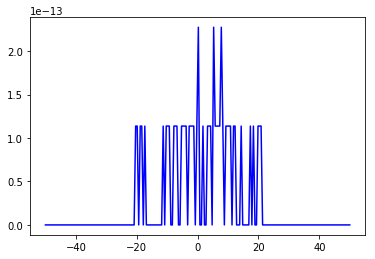

In [45]:
def potential_strog(theta):
    x_coord = np.linspace(-50,50,200)
    numeric_potential = lambdify((x,y),electric_potential(theta),'numpy')
    plt.plot(x_coord,np.abs(numeric_potential(x_coord,0)),'b')

potential_strog(120)

## Electric Field lines

In [38]:

def electricfiled_plot(theta=0):
    symbolical_pot = electric_potential(theta)
    numerical_pot = lambdify((x,y),symbolical_pot,'numpy')
    ex_symbolical, ey_symbolical = electric_field(theta)
    fig, ax = plt.subplots(figsize=(10,10))
    Ex = lambdify((x,y),ex_symbolical,'numpy')
    Ey = lambdify((x,y),ey_symbolical,'numpy')
    plt.streamplot(xx,yy,Ex(xx,yy),Ey(xx,yy),density=3,arrowsize=0.3,color='r',cmap='Greys')
    plt.xlim(-34,34)
    plt.ylim(-65,65)
    
Interactive_plot = interactive(electricfiled_plot,theta=(0,370,30))
Interactive_plot

interactive(children=(IntSlider(value=0, description='theta', max=370, step=30), Output()), _dom_classes=('wid…

In [58]:
def field_strog(theta):
    x_coord = np.linspace(-100,100,600)
    ex,ey = electric_field(theta)
    Ex = lambdify((x,y),ex,'numpy')
    Ey = lambdify((x,y),ey,'numpy')
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(x_coord,np.sqrt(Ex(x_coord,0)**2+Ey(x_coord,0)**2),'b')
    plt.xlim(-100,100)
    plt.ylim(0,500)
    plt.show()

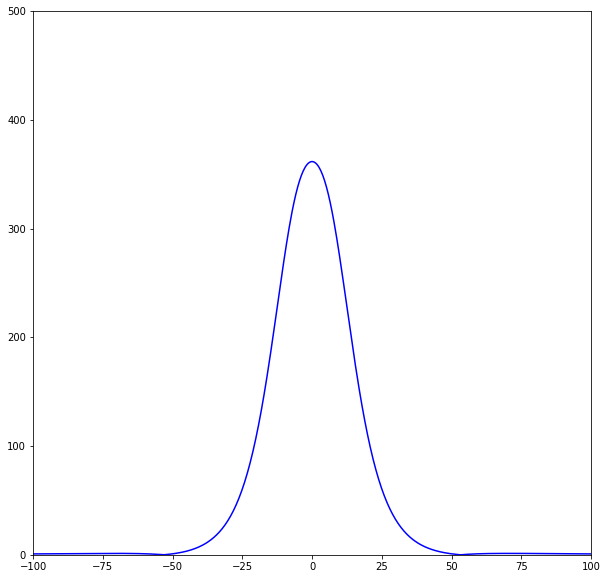

In [64]:
field_strog(200)

In [78]:
def field_y_strog(theta):
    x_coord = np.linspace(-100,100,600)
    ex,ey = electric_field(theta)
    Ex = lambdify((x,y),ex,'numpy')
    Ey = lambdify((x,y),ey,'numpy')
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(x_coord,np.abs(Ey(x_coord,10)),'b')
    plt.plot(x_coord,np.abs(Ex(x_coord,10)),'r')
    plt.xlim(-100,100)
    plt.ylim(0,700)
    plt.show()


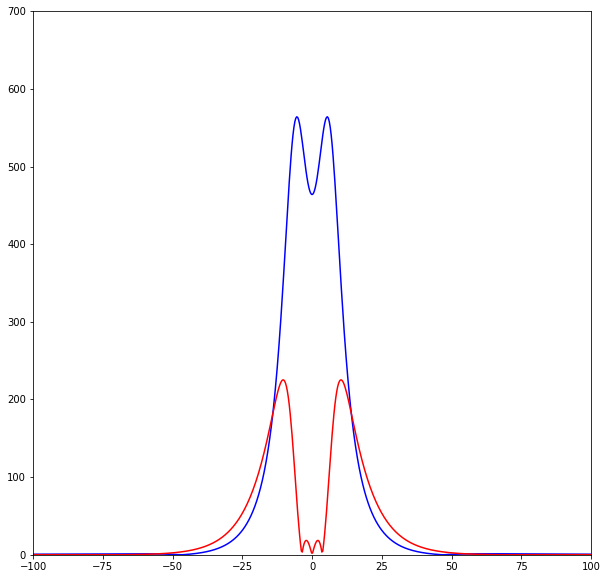

In [79]:
field_y_strog(0)

In [90]:
abs(Ex(-25,0.1)) , abs(Ex(25,0.1))

In [119]:
c1.area

In [173]:
ex_symbolical, ey_symbolical = electric_field(0)

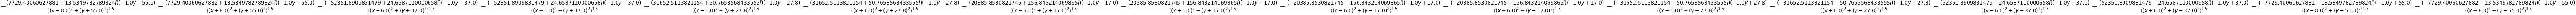

In [175]:
ey_symbolical